# Generate the Dataset
We are going to generate normally distributed values for each health variable, which are also going to be independant for each other.

For ouliers, they are going to be distant from the variable's mean, in a distance of at least 3 sigmas. We are going to identify inliers from outliers with the column "is_outlier".

In [1]:
import numpy as np
import pandas as pd

In [2]:
# define dataset parameters

params = {
    "hearth_rate":               {"mean": 80.0,  "std": 6.7, "min": 60.0,  "max": 100.0},
    "oxygen_saturation":         {"mean": 97.5,  "std": 0.8, "min": 95.0,  "max": 100.0},
    "breathing_rate":            {"mean": 16.0,  "std": 1.3, "min": 12.0,  "max": 20.0},
    "blood_pressure_systolic":   {"mean": 105.0, "std": 5.0, "min": 90.0,  "max": 120.0},
    "blood_presure_diastolic":   {"mean": 70.0,  "std": 3.3, "min": 60.0,  "max": 80.0},
    "body_temperature":          {"mean": 36.7,  "std": 0.2, "min": 36.1,  "max": 37.2},
}

dataset_size = 10000     # inliers
outlier_size = 100       # outliers
k_sigma = 5.0            # outliers minimum radial distance in z-scores
width = 1.0              # outliers ring thickness in z-scores
seed = 0                 # random seed for reproducibility

In [3]:
cols = list(params.keys())
mu   = np.array([params[c]["mean"] for c in cols])
stds = np.array([params[c]["std"]  for c in cols])
p    = len(cols)
rng  = np.random.default_rng(seed)

# Inliers (independent normals)
df_inliers = pd.DataFrame({
    c: rng.normal(params[c]["mean"], params[c]["std"], dataset_size) for c in cols
})
df_inliers["is_outlier"] = 1

# Outliers: radial shell (no rejection, exact size)
U = rng.normal(size=(outlier_size, p))
U = U / np.linalg.norm(U, axis=1, keepdims=True)        # unit directions
R = rng.uniform(k_sigma, k_sigma + width, (outlier_size, 1))  # radii
Z = U * R                                               # z-scores at desired radius
X = mu + Z * stds                                       # scale + shift

df_outliers = pd.DataFrame(X, columns=cols)
df_outliers["is_outlier"] = -1

# Final dataset
df = pd.concat([df_inliers, df_outliers], ignore_index=True)

In [4]:
# store as csv
df.to_csv('health_sensed_variables_dataset.csv', index=False)

In [5]:
df.shape

(10100, 7)

# Dataset Analysis
Some plots and statistics to explore the generated dataset

In [6]:
# show first columns
df.head()

,hearth_rate,oxygen_saturation,breathing_rate,blood_pressure_systolic,blood_presure_diastolic,body_temperature,is_outlier
0,80.842392,97.891526,16.420673,99.471810,70.580017,36.642781,1
1,79.114897,96.430763,17.464405,114.573197,68.629673,36.840147,1
2,84.290832,96.608935,16.178116,96.799187,69.259621,36.629311,1
3,80.702831,97.137639,16.749402,112.494754,72.717150,36.372384,1
4,76.411015,98.843859,16.325635,110.327587,71.813878,36.870559,1


In [7]:
# check that generated dataset has the required statistical properties
df.describe()

,hearth_rate,oxygen_saturation,breathing_rate,blood_pressure_systolic,blood_presure_diastolic,body_temperature,is_outlier
count,10100.000000,10100.000000,10100.000000,10100.000000,10100.000000,10100.000000,10100.000000
mean,80.039916,97.503010,16.008192,104.980032,69.992660,36.699340,0.980198
std,6.832839,0.811778,1.324749,5.176233,3.359338,0.202816,0.198030
min,41.999391,93.605990,10.157648,83.355033,56.265307,35.796121,-1.000000
25%,75.510995,96.964380,15.132710,101.560303,67.714974,36.566237,1.000000
50%,79.956086,97.496838,16.008891,104.987380,69.987805,36.699516,1.000000
75%,84.660178,98.050238,16.881361,108.378716,72.263304,36.832106,1.000000
max,112.245614,101.108701,22.539001,130.133204,87.814385,37.652184,1.000000


**Histogram: inliers vs outliers**

Here we can see that outliers are farther away from the mean (Mahalanobis distance)

In [12]:
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# z-scores
Xz = StandardScaler().fit_transform(df.drop(columns=["is_outlier"]))
r = np.linalg.norm(Xz, axis=1)  # ~ Mahalanobis if cov ≈ I after standardizing
y = (df["is_outlier"]==-1).values.astype(bool)

fig = go.Figure()
fig.add_trace(go.Histogram(x=r[~y], name="Inliers", nbinsx=60, opacity=0.6))
fig.add_trace(go.Histogram(x=r[y],  name="Outliers", nbinsx=60, opacity=0.8, marker_color="red"))
fig.update_layout(barmode="overlay", title="Radial distance Distribution(≈ Mahalanobis)")
fig.show()


**Radial Scatterplot**

Conveys the same information as the histogram, but presented as a scatterplot (visually easier to understand).

The cluster's center is the vector represented by the mean of each health variable, and every data point's location is determined by its distance to this mean vector (points further away are distance to the mean, and possibly outliers).

The angle at which each point is located is a dummy variable (for visual purposes). Only the distance to the cluster's center is important

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

# Data
cols = [c for c in df.columns if c != "is_outlier"]
X = df[cols].values
y = (df["is_outlier"]==-1).values.astype(bool)

# Standardize (z-scores)
Xz = StandardScaler().fit_transform(X)
r = np.linalg.norm(Xz, axis=1)  # radio (radial distance ≈ Mahalanobis)

# Angle just for separating points (does not contain information)
rng = np.random.default_rng(seed)
theta = rng.uniform(0, 2*np.pi, size=X.shape[0])

# 2D Coordinates
x2d = r * np.cos(theta)
y2d = r * np.sin(theta)

# Hover: show distance and health columns
custom_all = np.column_stack([r, X])

hovertemplate = (
    "<b>%{text}</b><br>"
    "r (≈ Mahalanobis)=%{customdata[0]:.2f}<br>" +
    "<br>".join([f"{c}=%{{customdata[{i+1}]:.2f}}" for i, c in enumerate(cols)]) +
    "<extra></extra>"
)

# Figure
fig = go.Figure()

# Inliers
fig.add_trace(go.Scatter(
    x=x2d[~y], y=y2d[~y], mode="markers", name="Inliers",
    marker=dict(size=6, color="blue", opacity=0.4),
    customdata=custom_all[~y],
    text=["Inlier"] * (~y).sum(),
    hovertemplate=hovertemplate
))

# Outliers
fig.add_trace(go.Scatter(
    x=x2d[y], y=y2d[y], mode="markers", name="Outliers",
    marker=dict(size=7, color="red", opacity=0.95),
    customdata=custom_all[y],
    text=["Outlier"] * y.sum(),
    hovertemplate=hovertemplate
))

fig.update_layout(
    title="Radial scatter — Inliers vs Outliers (r ≈ Mahalanobis Distance)",
    xaxis_title="x = r · cos(θ)",
    yaxis_title="y = r · sin(θ)",
    xaxis=dict(scaleanchor="y", scaleratio=1),  # escala 1:1
    legend=dict(x=0.02, y=0.98),
    hovermode="closest"
)

fig.show()
# fig.write_html("radial_scatter.html", include_plotlyjs="cdn")


**Scatterplot with all variables**

Considering that each health variable is normally distributed an independant, if some point is an outlier, it may not show in all dimensions (and so outliers are seen over the inliers cluster in some 2 dimensional plots). That means that the outlier has an odd value, but in another variable not shown in the plot.

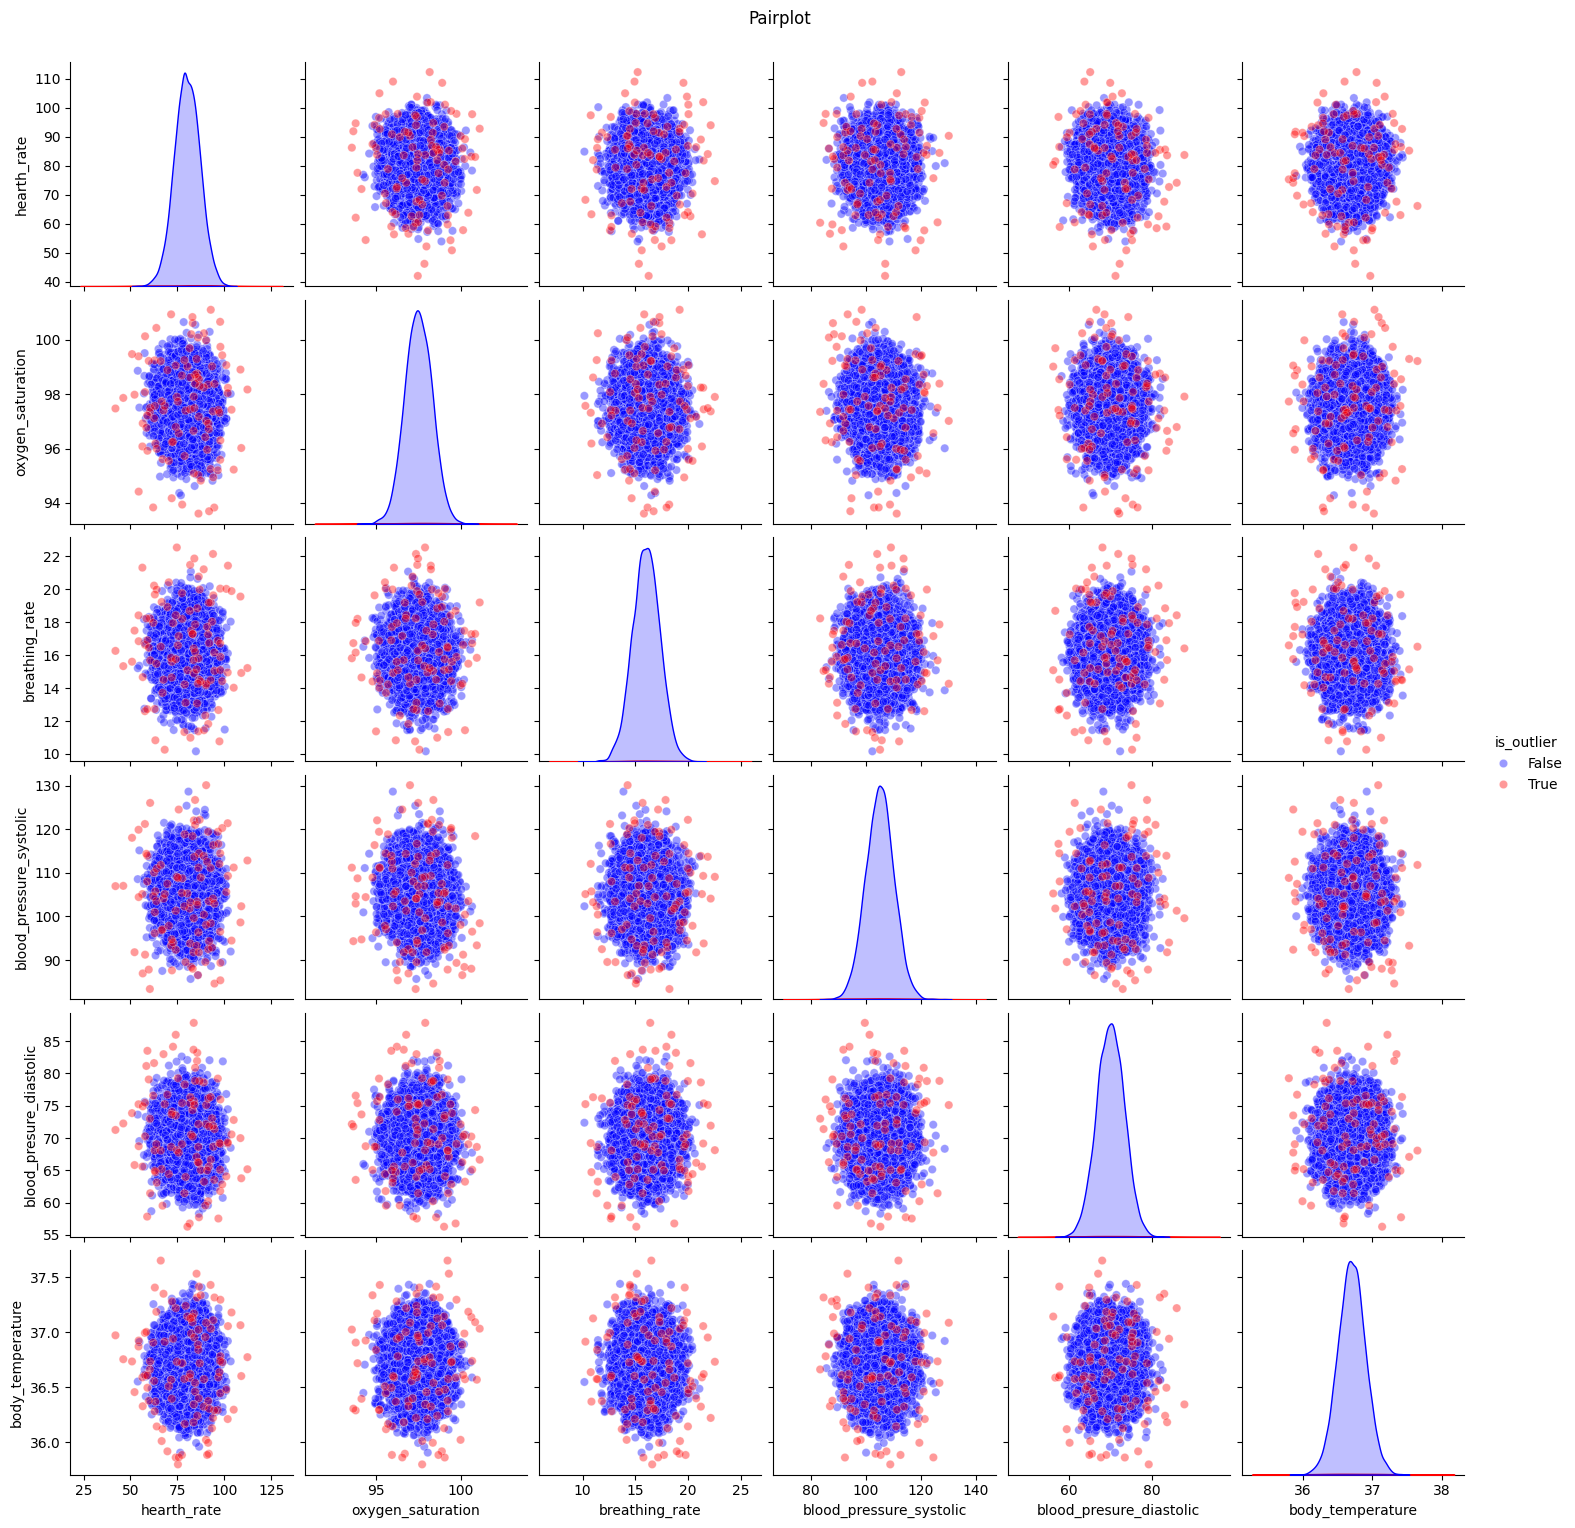

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only numerical variables
df_pair = df.drop(columns=["is_outlier"])

# Make a copy of df where "is_outlier" is binary
df2 = df.copy()
df2["is_outlier"] = df2["is_outlier"].map({1: False, -1: True})

# Pairplot where hue=is_outlier
sns.pairplot(
    df2,
    vars=df_pair.columns,
    hue="is_outlier",
    palette={False: "blue", True: "red"},
    plot_kws=dict(alpha=0.4)
)

plt.suptitle("Pairplot", y=1.02)
plt.show()


**Notes**
* As the variables are normally distributed and independant, PCA cannot decompose them, as every variable is equally important.
* t-SNE showed some results, but it is too slow to train and this won't allow interactive plots (bad user experience), so Radial distance was the chosen metric, as it is fast to calculate and allows to easily identify outliers.